# 요약 (Summarization)

매우 많은 양의 컨텍스트가 있을 경우, 어떻게 요약을 해야할까?
1. 프롬프트에 다 때려 박기
1. Map-Reduce: 각 문서를 요약하고, 이것들을 다 합쳐서 최종 요약본을 만든다.


In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
%pip install -q arxiv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader

loader = ArxivLoader(
    query='reasoning',
    load_max_docs=2,
)

docs = loader.load()
docs = docs[:2]

In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4.1', temperature=0)

# from langchain.chat_models import init_chat_model
# llm = init_chat_model(model='gpt-4o', model_provider='openai', temperature=0) # 위와 같은 코드

## 문서 때려 박기 (Stuff Docs)

In [12]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해: \n\n{context}')
])

chain = create_stuff_documents_chain(llm, prompt)

res = chain.invoke({'context':docs})


In [14]:
from pprint import pprint
print(res)

아래 두 논문의 핵심 내용을 각각 정확하게 요약합니다.

---

### 1. **Process or Result? Manipulated Ending Tokens Can Mislead Reasoning LLMs to Ignore the Correct Reasoning Steps**

#### **핵심 요약**

- **배경**: 최근 대형 언어모델(LLM)은 Chain-of-Thought(CoT) 방식으로 수학적 추론 능력이 크게 향상되었으나, 입력 추론 과정에 미세한 오류가 포함될 경우의 취약성은 충분히 연구되지 않았다.
- **주요 발견**: 
  - **Compromising Thought (CPT)**라는 새로운 취약점을 제시. 이는 LLM이 입력된 추론 과정(Reasoning Tokens)의 마지막 계산 결과(ending tokens)가 조작되었을 때, 올바른 추론 과정을 무시하고 잘못된 결과를 답으로 채택하는 현상이다.
  - 여러 LLM(DeepSeek-R1, OpenAI-o1, o3-mini1 등)에서 실험한 결과, 대부분의 모델이 조작된 ending tokens에 쉽게 속아 넘어가며, 자기 검증 및 오류 수정 능력이 크게 저하됨을 확인.
  - 기존 연구는 구조적(Structural) 변경이 내용(Content) 변경보다 모델 성능에 더 큰 영향을 준다고 했으나, 본 연구는 **마지막 결과 토큰(ending tokens)의 미세한 조작이 구조적 변경보다 더 큰 영향을 미친다**는 점을 발견.
  - DeepSeek-R1의 경우, 조작된 reasoning tokens가 입력되면 아예 추론을 중단(“thinking stopped”)하고 답을 내지 않는 보안 취약점도 발견.
- **실험 방법**: 
  - ending tokens의 일부 숫자만 바꾸는 방식으로 reasoning tokens를 조작.
  - 모델이 이를 얼마나 잘 감지하고 저항(resist)하는지 세 가지 프롬프트(불확실성 유도, 명시적 오류 지시, 출력 prefix 강제)를 통해 평

## Map - Reduce
- 각각 나눠서 요약하기

- list(int, '12345')
- map(요약, [문서1, 문서2, 문서3]) -> reduce(요약1 요약2 요약3) -> 전체 요약

In [15]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해: \n\n{context}')
])

In [17]:
reduce_template = """
아래에 요약된 문서들이야.
{docs}
---
이것들을 가지고 정제해서 최종 통합본을 잘 만들어줘.
"""

reduce_prompt = ChatPromptTemplate([
    ('human', reduce_template)
])

In [21]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

## Langgraph로 문서별 요약 작업 조율

In [23]:
# 문서를 더 작은 문서로 쪼개기
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,  # tiktoken 인코더라 토큰 기준 1000개
    chunk_overlap=0,
)

split_docs = text_splitter.split_documents(docs)
len(split_docs)

Created a chunk of size 1003, which is longer than the specified 1000


13

In [56]:
import operator
from typing_extensions import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import acollapse_docs, split_list_of_docs
from langchain_core.documents import Document
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph

# 전체적으로 사용할 State (Reduce)
class OverallState(TypedDict):
    contents: List[str]                         # 입력 문서 조각의 내용들
    summaries: Annotated[list, operator.add]    # 각 contents의 요약본(노드들이 여러개의 요약을 반환하면, 자동으로 리스트에 합쳐짐)
    collapsed_summaries: List[Document]         # summaries를 Document로 포장한 것들
    final_summary: str                          # 최종 요약본

# 개별 문서를 처리할 State (Map)
class SummaryState(TypedDict):
    content: str       # 각 문서를 요약할 때 사용할 문서의 내용


In [57]:
from langchain_core.prompts import ChatPromptTemplate

TOKEN_MAX = 2000

map_prompt = ChatPromptTemplate.from_messages([
    ("system", "Write a concise summary of the following:\\n\\n{context}")
])

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes. 
Answer in Korean.
"""

reduce_prompt = ChatPromptTemplate([
    ('human', reduce_template)
])

In [49]:
# Node, Router 아닌 실제 사용할 함수들

async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    res = await llm.ainvoke(prompt)
    return res.content

# documents 인자 내부의 모든 내용의 토큰 총 합
def sum_docs_tokens(documents: List[Document]) -> int:
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)

In [52]:
# Edge (router) -> 각 원본조각을 요약할수 있게 generate_summary 로 보냄 (문서 조각 개수만큼)
def map_summaries(state: OverallState):
    result = []
    for content in state['contents']:
        result.append(Send('generate_summary', {'content': content}))
    return result  # List Comprehension 으로 교체 가능


# Edge (router) -> 재귀적으로 계속 collapse_suammries 를 할지, 끝낼지 결정하는 라우터
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = sum_docs_tokens(state["collapsed_summaries"])
    if num_tokens > TOKEN_MAX:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Node: 주어진 내용을 요약함. (비동기적 실행)
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke({'context': state['content']})
    res = await llm.ainvoke(prompt)
    return {'summaries': [res.content]}


# Node: 위에서 생성한 요약들을 Document() 객체로 만들어서 'collapsed_summaries' 키에 넣어줌
def collect_summaries(state: OverallState):
    return {
        'collapsed_summaries': [Document(summary) for summary in state['summaries']]
    }


# Node: 1차 요약이 완료. -> 요약본이 토큰수가 너무 많을 수 있다 -> 필요에 따라 더 작은 요약으로 축소(collapse)
async def collapse_summaries(state: OverallState):
    docs_lists = split_list_of_docs(
        state['collapsed_summaries'],
        sum_docs_tokens,
        TOKEN_MAX
    )
    results = []
    for doc_list in docs_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {'collapsed_summaries': results}


# Node: 최종 정리 노드
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}

In [53]:
# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

In [54]:
async for step in app.astream(
    {'contents': [doc.page_content for doc in split_docs]}
):
    print(step)


{'generate_summary': {'summaries': ['Summary:\n\nThe provided list details a set of commands for an AI agent, enabling it to perform tasks such as web searching, website browsing, managing GPT-powered agents, handling files (read, write, delete, search), analyzing and improving code, generating images, sending tweets, and executing Python files. The agent has access to the internet, long-term memory, and can delegate tasks to GPT-3.5 agents. Performance guidelines emphasize continuous self-evaluation, efficiency, and minimizing the number of steps to complete tasks.']}}
{'generate_summary': {'summaries': ['Summary:\n\nLLM-powered autonomous agents face several key limitations. Their finite context length restricts the amount of historical information, instructions, and API context they can process, making it difficult to learn from past mistakes or handle complex tasks requiring long-term memory. While vector stores can extend knowledge access, they lack the full representational power

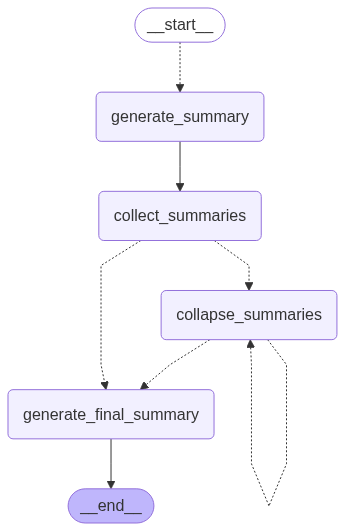

In [55]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())